# **Part 02:  Détection de Fraudes Bancaires**

## **Chargement et Exploration des données**

In [22]:
# Import des librairies 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns  


In [13]:
# Chargement du jeu de données 
data_path = "datasets/data_part2.txt"
# J'enregistre le jeu données en format csv vu que c'est plus pratique, on sait jamais :), les colonnes sont séparées par des ;
df=pd.read_csv(data_path, sep=";") 
df.to_csv("datasets/fraudes_bancaires.csv", index=False)

C:\Users\HP\AppData\Local\Temp\ipykernel_23076\1391828281.py:4: DtypeWarning: Columns (1,2,5,6,7,8,9,15,16,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(data_path, sep=";")


In [14]:
# Exploration du dataset

# Dimensions  
print("Dimensions du jeu de données :", df.shape)
# Apercu
print("Aperçu du jeu de données :")
print(df.head())
# Résumé des types 
print(df.info())
# Statistiques descriptives
print("Statistiques descriptives :")
print(df.describe())
# Valeurs manquantes par colonne: 
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

Dimensions du jeu de données : (4646774, 23)
Aperçu du jeu de données :
                      ZIBZIN IDAvisAutorisationCheque FlagImpaye  \
0  A013010004908126703060931                 78643044          0   
1  A013011306908024927155000                 78643045          0   
2  A013010002908283134592527                 78643046          0   
3  A011010002908105209831316                 78643047          0   
4  A013010041908000125652029                 78643048          0   

              Montant      DateTransaction CodeDecision VerifianceCPT1  \
0                  20  2017-02-01 07:32:14            1              0   
1                  20  2017-02-01 07:43:37            1              0   
2  57,640000000000001  2017-02-01 07:47:38            1              0   
3  54,289999999999999  2017-02-01 07:48:48            0              1   
4  26,899999999999999  2017-02-01 08:13:27            1              0   

  VerifianceCPT2 VerifianceCPT3 D2CB  ...        TauxImpNb_RB  \
0        

## **Prétraitement des données**

In [16]:
# Typage de la colonne DateTransaction
# On change la colonne de date en format datetime pour pouvoir faire le split temporel
df["DateTransaction"] = pd.to_datetime(df["DateTransaction"], errors="coerce")
# Vérifier qu'on n'a pas trop de NaT
print("Nombre de NaT dans DateTransaction :", df["DateTransaction"].isna().sum())
# On vérifie que le tri chronologique est cohérent
df = df.sort_values("DateTransaction").reset_index(drop=True)
# Contrôle des bornes temporelles
print("Date min :", df["DateTransaction"].min())
print("Date max :", df["DateTransaction"].max())


Nombre de NaT dans DateTransaction : 1
Date min : 2017-02-01 07:32:14
Date max : 2017-11-30 22:07:13


In [18]:
# Vu qu'on a une seule ligne qui ne correspond pas au format datetime, on va la supprimer
df = df.dropna(subset=["DateTransaction"]).reset_index(drop=True)

# petite vérif 
print("Nombre de NaT dans DateTransaction :", df["DateTransaction"].isna().sum())

Nombre de NaT dans DateTransaction : 0


In [19]:
# Séparation des colonnes quantitatives et qualitativesselon la définition dans l'énoncé du projet 
# Colonnes qualitatives : colonnes des identifiants
col_quali = ["ZIBZIN", "IDAvisAutorisationCheque"]

# Colonnes quantitatives : features + cible
col_quanti = [
    "FlagImpaye",
    "Montant",
    "CodeDecision",
    "VerifianceCPT1",
    "VerifianceCPT2",
    "VerifianceCPT3",
    "D2CB",
    "ScoringFP1",
    "ScoringFP2",
    "ScoringFP3",
    "TauxImpNb_RB",
    "TauxImpNB_CPM",
    "EcartNumCheq",
    "NbrMagasin3J",
    "DiffDateTr1",
    "DiffDateTr2",
    "DiffDateTr3",
    "CA3TRetMtt",
    "CA3TR",
    "Heure",
]


In [20]:
# Typage des colonnes selon le type 
# colonnes qualitatives en object : elles y sont déjà
for col in col_quali:
    if col in df.columns:
        df[col] = df[col].astype("object")

# colonnes quantitatives 
# On commence par un nettoyage très simple  :
#    - on remplace les virgules par des points
#    - on convertit en numérique, valeurs invalides -> NaN

for col in col_quanti:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(",", ".", regex=False)
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Vérification 
print("\nTypes des colonnes après typage :")
print(df.dtypes)


Types des colonnes après typage :
ZIBZIN                              object
IDAvisAutorisationCheque            object
FlagImpaye                           int64
Montant                            float64
DateTransaction             datetime64[ns]
CodeDecision                         int64
VerifianceCPT1                       int64
VerifianceCPT2                       int64
VerifianceCPT3                       int64
D2CB                                 int64
ScoringFP1                         float64
ScoringFP2                         float64
ScoringFP3                         float64
TauxImpNb_RB                       float64
TauxImpNB_CPM                      float64
EcartNumCheq                         int64
NbrMagasin3J                         int64
DiffDateTr1                        float64
DiffDateTr2                        float64
DiffDateTr3                        float64
CA3TRetMtt                         float64
CA3TR                              float64
Heure              


Distribution de la variable cible FlagImpaye :
FlagImpaye
0    4616778
1      29995
Name: count, dtype: int64
Taux de fraudes (FlagImpaye=1) : 0.65%


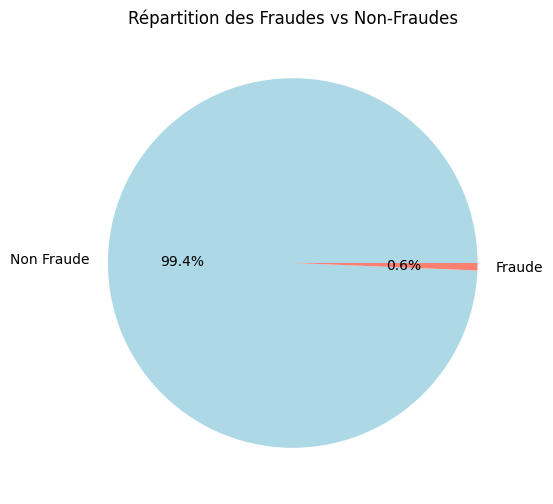

In [27]:
# Maintenant on vérifie la colonne cible et on regarde sa distribution pour detecter le déséquilibre
print("\nDistribution de la variable cible FlagImpaye :")
print(df["FlagImpaye"].value_counts())

# On affiche les pourcentages
fraud_rate = df["FlagImpaye"].mean()
# sous forme de pourcentage 
print(f"Taux de fraudes (FlagImpaye=1) : {fraud_rate*100:.2f}%")

# On fait un petit graphique circulaire pour mieux voir  
plt.figure(figsize=(6, 6))
df["FlagImpaye"].value_counts().plot.pie(
    autopct="%1.1f%%",
    colors=["lightblue", "salmon"],
    labels=["Non Fraude", "Fraude"]
)
plt.ylabel("")  
plt.title("Répartition des Fraudes vs Non-Fraudes")
plt.show()
 

In [ ]:
# Split temporel des données train et test 

# Période d'apprentissage : 2017-02-01 au 2017-08-31
start_train = pd.to_datetime("2017-02-01")
end_train   = pd.to_datetime("2017-08-31")

# Période de test : 2017-09-01 au 2017-11-30
start_test = pd.to_datetime("2017-09-01")
end_test   = pd.to_datetime("2017-11-30")

mask_train = (df["DateTransaction"] >= start_train) & (df["DateTransaction"] <= end_train)
mask_test  = (df["DateTransaction"] >= start_test) & (df["DateTransaction"] <= end_test)

train_df = df[mask_train].copy()
test_df  = df[mask_test].copy()

print("Taille train :", train_df.shape)
print("Taille test  :", test_df.shape)


Taille train : (3888468, 23)
Taille test  : (737068, 23)


In [29]:
# Séparation des features et de la cible

target_col = "FlagImpaye"

# Colonnes à exclure explicitement des features: colonnes non pertiennentes 
cols_to_drop = [
    "FlagImpaye",           # cible
    "CodeDecision",         # info post-transaction, à ne pas utiliser en prédiction
    "IDAvisAutorisAtionCheque",  # identifiant de transaction
    "ZIBZIN",               # identifiant client/chèque
    "DateTransaction"       # déjà utilisé pour le split, pas forcément utile comme feature brute, de plus ça peut poser des problèmes de fuites temporelles
]

# On garde uniquement les colonnes qui ne sont pas dans cols_to_drop
feature_cols = [c for c in df.columns if c not in cols_to_drop]

print("Nombre de variables explicatives :", len(feature_cols))
print("Liste des variables utilisées :")
print(feature_cols)


Nombre de variables explicatives : 19
Liste des variables utilisées :
['IDAvisAutorisationCheque', 'Montant', 'VerifianceCPT1', 'VerifianceCPT2', 'VerifianceCPT3', 'D2CB', 'ScoringFP1', 'ScoringFP2', 'ScoringFP3', 'TauxImpNb_RB', 'TauxImpNB_CPM', 'EcartNumCheq', 'NbrMagasin3J', 'DiffDateTr1', 'DiffDateTr2', 'DiffDateTr3', 'CA3TRetMtt', 'CA3TR', 'Heure']


In [30]:
# Construction de X et y pour train et test
X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].copy()

print("X_train :", X_train.shape, "| y_train :", y_train.shape)
print("X_test  :", X_test.shape,  "| y_test  :", y_test.shape)

X_train : (3888468, 19) | y_train : (3888468,)
X_test  : (737068, 19) | y_test  : (737068,)


## **Choix des modèles**

On a décidé d'utiliser plusieurs familles de modèles afin de comparer leurs performances en détection de fraude sur ce jeu de données fortement déséquilibré. Les modèles sont toujours testés en version **brute** puis avec des **méthodes de prétraitement** adaptées au déséquilibre (sur‑échantillonnage, pondération des classes, et une variante d’undersampling simple).

- **Méthode non paramétrique : K‑plus proches voisins (KNN)**  
  Utilisé seul, puis avec un sur‑échantillonnage de la classe minoritaire (SMOTE) pour améliorer la détection des fraudes.

- **Méthode non linéaire : Forêt aléatoire**  
  Utilisée en version standard, puis avec une approche cost‑sensitive via `class_weight` pour mieux tenir compte du déséquilibre de classes. Une deuxième variante avec undersampling de la classe majoritaire pour comparer l’impact de la réduction du nombre de transactions non frauduleuses.

- **Méthode linéaire : Régression logistique**  
  Baseline linéaire, testée brute puis avec `class_weight` pour pondérer davantage la classe fraude.

- **Méthode non supervisée : k‑means**  
  Utilisée pour repérer des clusters de transactions atypiques, sans utiliser directement la cible pendant l’apprentissage.

- **Méthode ensembliste : vote de modèles**  
  Combinaison de plusieurs modèles supervisés afin d’exploiter leur complémentarité et d’améliorer la F1.
